<a href="https://colab.research.google.com/github/kinan-02/Fintech/blob/main/eval_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [111]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from tqdm import tqdm
import random
# Load the Parquet file

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)  # Set a fixed seed for CPU
if torch.cuda.is_available():
    torch.cuda.manual_seed(0)  # Set seed for all CUDA devices
    torch.cuda.manual_seed_all(0)  # If you are using multiple GPUs

# If you're using cudnn backend for performance improvements, you should set the following to ensure deterministic behavior
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

df = pd.read_parquet('final_data.parquet')
df_test = pd.read_parquet('test_data.parquet')

# Define features and target (next-minute close price of Bitcoin)
features = df[['open_btc', 'high_btc', 'low_btc', 'trade_count_btc',
               'open_eth', 'high_eth', 'low_eth', 'close_eth', 'trade_count_eth',
               'open_cl', 'close_cl', 'high_cl', 'low_cl', 'trade_count_cl',
               'open_gold', 'close_gold', 'high_gold', 'low_gold', 'trade_count_gold',
               'open_uup', 'close_uup', 'high_uup', 'low_uup', 'trade_count_uup',
               'open_mstr', 'close_mstr', 'high_mstr', 'low_mstr', 'trade_count_mstr',
               'open_spy', 'close_spy', 'high_spy', 'low_spy', 'trade_count_spy',
               'open_ndaq', 'close_ndaq', 'high_ndaq', 'low_ndaq', 'trade_count_ndaq']]

test_features = df_test[['open_btc', 'high_btc', 'low_btc', 'trade_count_btc',
               'open_eth', 'high_eth', 'low_eth', 'close_eth', 'trade_count_eth',
               'open_cl', 'close_cl', 'high_cl', 'low_cl', 'trade_count_cl',
               'open_gold', 'close_gold', 'high_gold', 'low_gold', 'trade_count_gold',
               'open_uup', 'close_uup', 'high_uup', 'low_uup', 'trade_count_uup',
               'open_mstr', 'close_mstr', 'high_mstr', 'low_mstr', 'trade_count_mstr',
               'open_spy', 'close_spy', 'high_spy', 'low_spy', 'trade_count_spy',
               'open_ndaq', 'close_ndaq', 'high_ndaq', 'low_ndaq', 'trade_count_ndaq']]

# Target: next-minute close price of Bitcoin
target = df['close_btc'].shift(-1)  # Shift by -1 to predict next-minute close price
target_test = df_test['close_btc']

# Drop the last row (since it doesn't have a valid target)
features = features[:-1]
target = target[:-1]
test_features = test_features[:-1]
target_test = target_test[:-1]

# Scale the features
scaler = MinMaxScaler()
features = scaler.fit_transform(features)
test_features = scaler.transform(test_features)

# Manually split into training (first 80%) and testing (last 20%) without shuffling
# split_index = int(0.8 * len(features))

# X_train, X_test = features[:split_index], features[split_index:]
# y_train, y_test = target[:split_index], target[split_index:]

X_train, X_test = features, test_features
y_train, y_test = target, target_test

# Convert to tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.float32)
y_test = torch.tensor(y_test.values, dtype=torch.float32)

# Create DataLoader for training data
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Create DataLoader for test data (optional for evaluation)
test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)



# Evaluate the Model (Use the trained model as an argument)
def calculate_var(returns, confidence_level=90):
    """
    Calculate Value at Risk (VaR) for a given set of returns and confidence level.
    """
    return np.percentile(returns, 100 - confidence_level)


def evaluate_model(model):
    model.eval()
    predictions = []
    actuals = []
    total_loss = 0
    total_percentage_loss = 0  # To track percentage loss
    total_mape = 0  # To track MAPE
    loss_fn = torch.nn.MSELoss()

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            output = model(X_batch)
            loss = loss_fn(output, y_batch)
            total_loss += loss.item()

            # Calculate loss as a percentage (relative error)
            percentage_loss = torch.sqrt(loss) / (torch.mean(y_batch) + 1e-10) * 100
            total_percentage_loss += percentage_loss.item()

            # Calculate Mean Absolute Percentage Error (MAPE)
            mape = torch.mean(torch.abs((y_batch - output) / (y_batch + 1e-10))) * 100
            total_mape += mape.item()

            predictions.append(output.numpy())
            actuals.append(y_batch.numpy())

    # Calculate the predicted returns and real returns
    predictions[-1] = np.repeat(predictions[-1], 32)
    predictions = np.concatenate(predictions, axis=0)
    actuals = np.concatenate(actuals, axis=0)

    # Calculate returns as percentage change between consecutive predictions
    predicted_returns = (predictions[1:] - predictions[:-1]) / predictions[:-1]
    real_returns = (actuals[1:] - actuals[:-1]) / actuals[:-1]

    # Calculate predicted VaR and real VaR at 95% confidence level
    predicted_var = calculate_var(predicted_returns, confidence_level=90)
    real_var = calculate_var(real_returns, confidence_level=90)

    print(f"Test Loss: {total_loss / len(test_loader):.6f}")
    print(f"Test Loss as Percentage: {total_percentage_loss / len(test_loader):.2f}%")
    print(f"Predicted VaR (95% confidence): {predicted_var}")
    print(f"Real VaR (95% confidence): {real_var}")
    print(f"Mean Absolute Percentage Error (MAPE): {total_mape / len(test_loader):.2f}%")
    return predictions, actuals

#BaseLine (LSTM) Model Eval

In [112]:
class LSTM(nn.Module):
    def __init__(self, n_layers, tr_layers, n_heads_first, n_heads_second, input_dim, hidden_dim, output_dim, dropout):
        super().__init__()
        self.n_layers = n_layers
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.dropout = dropout
        self.tr_layers = tr_layers
        self.n_heads_first = n_heads_first
        self.n_heads_second = n_heads_second

        self.weight_lstm = nn.Parameter(torch.rand(1), requires_grad=True)
        self.weight_transform = nn.Parameter(torch.rand(1), requires_grad=True)
        self.weight_transform2 = nn.Parameter(torch.rand(1), requires_grad=True)
        # self.weight_attn = nn.Parameter(torch.rand(1), requires_grad=True)

        # Initial fully connected layers to project input features
        self.input_fc = nn.Sequential(
            nn.Linear(input_dim, input_dim * 2),
            nn.Dropout(dropout),
            nn.ReLU(),
            nn.Linear(input_dim * 2, hidden_dim),
            nn.Dropout(dropout),
            nn.ReLU()
        )

        # LSTM layers
        self.main_task = nn.LSTM(input_size=hidden_dim,
                                 hidden_size=hidden_dim,
                                 batch_first=True,
                                 num_layers=n_layers,
                                 dropout=dropout)

        self.last_task = nn.LSTM(input_size=hidden_dim,
                                 hidden_size=hidden_dim,
                                 batch_first=True,
                                 num_layers=n_layers,
                                 dropout=dropout)

        # Transformer layers
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=hidden_dim, nhead=self.n_heads_first,
                                                        dim_feedforward=hidden_dim * 4,
                                                        dropout=dropout,
                                                        activation='relu',
                                                        batch_first=True)
        self.transformer = nn.TransformerEncoder(self.encoder_layer, num_layers=self.tr_layers)

        self.encoder_layer2 = nn.TransformerEncoderLayer(d_model=hidden_dim, nhead=self.n_heads_second,
                                                         dim_feedforward=hidden_dim,
                                                         dropout=dropout,
                                                         activation='relu',
                                                         batch_first=True)
        self.transformer2 = nn.TransformerEncoder(self.encoder_layer2, num_layers=self.tr_layers)

        # Final fully connected layer to project to output (next-minute close price)
        self.output_fc = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, output_dim)
        )


    def generate_mask(self, size):
        """
        Generate a causal mask for the Transformer, preventing future positions from attending to earlier positions.
        """
        mask = torch.triu(torch.ones(size, size) * float('-inf'), diagonal=1)
        return mask

    def forward(self, input_vec):
        # Pass through input FC layers
        lstm_input = self.input_fc(input_vec)
        # LSTM layer
        final_output, _ = self.main_task(lstm_input)


        # Output layer for the predicted close price
        output = self.output_fc(final_output)

        return output.squeeze()

In [113]:
# Initialize the model structure
model = LSTM(
        n_layers=1, tr_layers=1, n_heads_first=4, n_heads_second=1,
        input_dim=X_train.shape[1], hidden_dim=32, output_dim=1, dropout=0
    )

# Load the saved state dictionary into the model
model.load_state_dict(torch.load('baseline.pth'))

baseline_pred,actuals = evaluate_model(model)


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
<ipython-input-113-4b34d78c95ea>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.seri

Test Loss: 4162.417426
Test Loss as Percentage: 0.09%
Predicted VaR (95% confidence): -0.0008045249851420522
Real VaR (95% confidence): -0.0006554247112944722
Mean Absolute Percentage Error (MAPE): 0.06%


#Transformer Model Eval

In [114]:
# Transformer Model Definition
class Transformer(nn.Module):
    def __init__(self, n_layers, tr_layers, n_heads_first, n_heads_second, input_dim, hidden_dim, output_dim, dropout):
        super().__init__()
        self.n_layers = n_layers
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.dropout = dropout
        self.tr_layers = tr_layers
        self.n_heads_first = n_heads_first
        self.n_heads_second = n_heads_second

        self.weight_lstm = nn.Parameter(torch.rand(1), requires_grad=True)
        self.weight_transform = nn.Parameter(torch.rand(1), requires_grad=True)
        self.weight_transform2 = nn.Parameter(torch.rand(1), requires_grad=True)
        self.weight_attn = nn.Parameter(torch.rand(1), requires_grad=True)

        # Initial fully connected layers to project input features
        self.input_fc = nn.Sequential(
            nn.Linear(input_dim, input_dim * 2),
            nn.Dropout(dropout),
            nn.ReLU(),
            nn.Linear(input_dim * 2, hidden_dim),
            nn.Dropout(dropout),
            nn.ReLU()
        )

        # LSTM layers
        self.main_task = nn.LSTM(input_size=hidden_dim,
                                 hidden_size=hidden_dim,
                                 batch_first=True,
                                 num_layers=n_layers,
                                 dropout=dropout)

        self.last_task = nn.LSTM(input_size=hidden_dim,
                                 hidden_size=hidden_dim,
                                 batch_first=True,
                                 num_layers=n_layers,
                                 dropout=dropout)

        # Transformer layers
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=hidden_dim, nhead=self.n_heads_first,
                                                        dim_feedforward=hidden_dim * 4,
                                                        dropout=dropout,
                                                        activation='relu',
                                                        batch_first=True)
        self.transformer = nn.TransformerEncoder(self.encoder_layer, num_layers=self.tr_layers)

        self.encoder_layer2 = nn.TransformerEncoderLayer(d_model=hidden_dim, nhead=self.n_heads_second,
                                                         dim_feedforward=hidden_dim,
                                                         dropout=dropout,
                                                         activation='relu',
                                                         batch_first=True)
        self.transformer2 = nn.TransformerEncoder(self.encoder_layer2, num_layers=self.tr_layers)

        # Final fully connected layer to project to output (next-minute close price)
        self.output_fc = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, output_dim)
        )

    def generate_mask(self, size):
        """
        Generate a causal mask for the Transformer, preventing future positions from attending to earlier positions.
        """
        mask = torch.triu(torch.ones(size, size) * float('-inf'), diagonal=1)
        return mask

    def forward(self, input_vec):
        # Pass through input FC layers
        lstm_input = self.input_fc(input_vec)

        # Generate mask for Transformer based on sequence length
        seq_len,a = input_vec.size()
        mask = torch.triu(torch.ones(seq_len, seq_len), diagonal=1)  # Upper triangular mask
        mask = mask.masked_fill(mask == 1, float('-inf'))  # Replace 1s with -inf for masking
        transformer_output = self.transformer(lstm_input, mask=mask)

        # Output layer for the predicted close price
        output = self.output_fc(transformer_output)

        return output.squeeze()  # Ensure output shape is correct



In [115]:
# Initialize the model structure
model = Transformer(
        n_layers=1, tr_layers=1, n_heads_first=4, n_heads_second=1,
        input_dim=X_train.shape[1], hidden_dim=32, output_dim=1, dropout=0
    )

# Load the saved state dictionary into the model
model.load_state_dict(torch.load('transformer_model.pth'))

transformer_pred,actuals = evaluate_model(model)


<ipython-input-115-c3efeabe3af4>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('transformer_model.pth'))


Test Loss: 1968.874631
Test Loss as Percentage: 0.06%
Predicted VaR (95% confidence): -0.0006499371374957263
Real VaR (95% confidence): -0.0006554247112944722
Mean Absolute Percentage Error (MAPE): 0.05%


#Transformer-LSTM Model Eval

In [116]:
class Transformer_LSTM(nn.Module):
    def __init__(self, n_layers, tr_layers, n_heads_first, n_heads_second, input_dim, hidden_dim, output_dim, dropout):
        super().__init__()
        self.n_layers = n_layers
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.dropout = dropout
        self.tr_layers = tr_layers
        self.n_heads_first = n_heads_first
        self.n_heads_second = n_heads_second

        self.weight_lstm = nn.Parameter(torch.rand(1), requires_grad=True)
        self.weight_transform = nn.Parameter(torch.rand(1), requires_grad=True)
        self.weight_transform2 = nn.Parameter(torch.rand(1), requires_grad=True)
        # self.weight_attn = nn.Parameter(torch.rand(1), requires_grad=True)

        # Initial fully connected layers to project input features
        self.input_fc = nn.Sequential(
            nn.Linear(input_dim, input_dim * 2),
            nn.Dropout(dropout),
            nn.ReLU(),
            nn.Linear(input_dim * 2, hidden_dim),
            nn.Dropout(dropout),
            nn.ReLU()
        )

        # LSTM layers
        self.main_task = nn.LSTM(input_size=hidden_dim,
                                 hidden_size=hidden_dim,
                                 batch_first=True,
                                 num_layers=n_layers,
                                 dropout=dropout)

        self.last_task = nn.LSTM(input_size=hidden_dim,
                                 hidden_size=hidden_dim,
                                 batch_first=True,
                                 num_layers=n_layers,
                                 dropout=dropout)

        # Transformer layers
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=hidden_dim, nhead=self.n_heads_first,
                                                        dim_feedforward=hidden_dim * 4,
                                                        dropout=dropout,
                                                        activation='relu',
                                                        batch_first=True)
        self.transformer = nn.TransformerEncoder(self.encoder_layer, num_layers=self.tr_layers)

        self.encoder_layer2 = nn.TransformerEncoderLayer(d_model=hidden_dim, nhead=self.n_heads_second,
                                                         dim_feedforward=hidden_dim,
                                                         dropout=dropout,
                                                         activation='relu',
                                                         batch_first=True)
        self.transformer2 = nn.TransformerEncoder(self.encoder_layer2, num_layers=self.tr_layers)

        # Final fully connected layer to project to output (next-minute close price)
        self.output_fc = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, output_dim)
        )

    def generate_mask(self, size):
        """
        Generate a causal mask for the Transformer, preventing future positions from attending to earlier positions.
        """
        mask = torch.triu(torch.ones(size, size) * float('-inf'), diagonal=1)
        return mask

    def forward(self, input_vec):
        # Pass through input FC layers
        lstm_input = self.input_fc(input_vec)

        # Generate mask for Transformer based on sequence length
        seq_len,a = input_vec.size()
        mask = torch.triu(torch.ones(seq_len, seq_len), diagonal=1)  # Upper triangular mask
        mask = mask.masked_fill(mask == 1, float('-inf'))  # Replace 1s with -inf for masking
        transformer_output1 = self.transformer(lstm_input, mask=mask)
        # LSTM layer
        lstm_output, _ = self.main_task(transformer_output1)

        # Output layer for the predicted close price
        output = self.output_fc(lstm_output)

        return output.squeeze()

In [117]:
# Initialize the model structure
model = Transformer_LSTM(
        n_layers=1, tr_layers=1, n_heads_first=4, n_heads_second=1,
        input_dim=X_train.shape[1], hidden_dim=32, output_dim=1, dropout=0
    )

# Load the saved state dictionary into the model
model.load_state_dict(torch.load('transformer_lstm.pth'))

transformer_lstm_pred,actuals = evaluate_model(model)


<ipython-input-117-4747df1fc193>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('transformer_lstm.pth'))


Test Loss: 3007.021862
Test Loss as Percentage: 0.08%
Predicted VaR (95% confidence): -0.0007155124330893159
Real VaR (95% confidence): -0.0006554247112944722
Mean Absolute Percentage Error (MAPE): 0.07%


#Final Model Eval

In [118]:
class LSTM_Transformer(nn.Module):
    def __init__(self, n_layers, tr_layers, n_heads_first, n_heads_second, input_dim, hidden_dim, output_dim, dropout):
        super().__init__()
        self.n_layers = n_layers
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.dropout = dropout
        self.tr_layers = tr_layers
        self.n_heads_first = n_heads_first
        self.n_heads_second = n_heads_second

        self.weight_lstm = nn.Parameter(torch.rand(1), requires_grad=True)
        self.weight_transform = nn.Parameter(torch.rand(1), requires_grad=True)
        self.weight_transform2 = nn.Parameter(torch.rand(1), requires_grad=True)
        # self.weight_attn = nn.Parameter(torch.rand(1), requires_grad=True)

        # Initial fully connected layers to project input features
        self.input_fc = nn.Sequential(
            nn.Linear(input_dim, input_dim * 2),
            nn.Dropout(dropout),
            nn.ReLU(),
            nn.Linear(input_dim * 2, hidden_dim),
            nn.Dropout(dropout),
            nn.ReLU()
        )

        # LSTM layers
        self.main_task = nn.LSTM(input_size=hidden_dim,
                                 hidden_size=hidden_dim,
                                 batch_first=True,
                                 num_layers=n_layers,
                                 dropout=dropout)

        self.last_task = nn.LSTM(input_size=hidden_dim,
                                 hidden_size=hidden_dim,
                                 batch_first=True,
                                 num_layers=n_layers,
                                 dropout=dropout)

        # Transformer layers
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=hidden_dim, nhead=self.n_heads_first,
                                                        dim_feedforward=hidden_dim * 4,
                                                        dropout=dropout,
                                                        activation='relu',
                                                        batch_first=True)
        self.transformer = nn.TransformerEncoder(self.encoder_layer, num_layers=self.tr_layers)

        self.encoder_layer2 = nn.TransformerEncoderLayer(d_model=hidden_dim, nhead=self.n_heads_second,
                                                         dim_feedforward=hidden_dim,
                                                         dropout=dropout,
                                                         activation='relu',
                                                         batch_first=True)
        self.transformer2 = nn.TransformerEncoder(self.encoder_layer2, num_layers=self.tr_layers)

        # Final fully connected layer to project to output (next-minute close price)
        self.output_fc = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, output_dim)
        )

    def generate_mask(self, size):
        """
        Generate a causal mask for the Transformer, preventing future positions from attending to earlier positions.
        """
        mask = torch.triu(torch.ones(size, size) * float('-inf'), diagonal=1)
        return mask

    def forward(self, input_vec):
        # Pass through input FC layers
        lstm_input = self.input_fc(input_vec)

        # Generate mask for Transformer based on sequence length
        seq_len,a = input_vec.size()
        mask = torch.triu(torch.ones(seq_len, seq_len), diagonal=1)  # Upper triangular mask
        mask = mask.masked_fill(mask == 1, float('-inf'))  # Replace 1s with -inf for masking
        transformer_output1 = self.transformer(lstm_input, mask=mask)
        transformer_output2 = self.transformer2(lstm_input, mask=mask)

        # LSTM layer
        lstm_output, _ = self.main_task(lstm_input)

        # Combine Transformer and LSTM outputs
        lstm_output = self.weight_transform*transformer_output1 + self.weight_lstm*lstm_output + self.weight_transform2*transformer_output2
        lstm_output /= (self.weight_lstm + self.weight_transform + self.weight_transform2)

        # Pass through last LSTM layer
        final_output, _ = self.last_task(lstm_output)

        # Output layer for the predicted close price
        output = self.output_fc(final_output)

        return output.squeeze()

In [119]:
import pickle , time
with open("final_model.pkl", "rb") as f:
    model = pickle.load(f)
start_time = time.time()
final_model_pred,acutals = evaluate_model(model)
end_time = time.time()
time_taken = end_time - start_time
print(f"Evaluation time: {time_taken:.4f} seconds")

Test Loss: 789.675891
Test Loss as Percentage: 0.04%
Predicted VaR (95% confidence): -0.0007364198099821806
Real VaR (95% confidence): -0.0006554247112944722
Mean Absolute Percentage Error (MAPE): 0.03%
Evaluation time: 4.7021 seconds


#Hybrid Sequential-Context Transformer LSTM (HSCT-LSTM) Model Eval

In [120]:
class HSCT_LSTM(nn.Module):
    def __init__(self, n_layers, tr_layers, n_heads_first, n_heads_second, input_dim, hidden_dim, output_dim, dropout):
        super().__init__()
        self.n_layers = n_layers
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.dropout = dropout
        self.tr_layers = tr_layers
        self.n_heads_first = n_heads_first
        self.n_heads_second = n_heads_second

        self.weight_lstm = nn.Parameter(torch.rand(1), requires_grad=True)
        self.weight_transform = nn.Parameter(torch.rand(1), requires_grad=True)
        self.weight_transform2 = nn.Parameter(torch.rand(1), requires_grad=True)
        # self.weight_attn = nn.Parameter(torch.rand(1), requires_grad=True)

        # Initial fully connected layers to project input features
        self.input_fc = nn.Sequential(
            nn.Linear(input_dim, input_dim * 2),
            nn.Dropout(dropout),
            nn.ReLU(),
            nn.Linear(input_dim * 2, hidden_dim),
            nn.Dropout(dropout),
            nn.ReLU()
        )

        # LSTM layers
        self.main_task = nn.LSTM(input_size=hidden_dim,
                                 hidden_size=hidden_dim,
                                 batch_first=True,
                                 num_layers=n_layers,
                                 dropout=dropout)

        self.last_task = nn.LSTM(input_size=hidden_dim,
                                 hidden_size=hidden_dim,
                                 batch_first=True,
                                 num_layers=n_layers,
                                 dropout=dropout)

        # Transformer layers
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=hidden_dim, nhead=self.n_heads_first,
                                                        dim_feedforward=hidden_dim * 4,
                                                        dropout=dropout,
                                                        activation='relu',
                                                        batch_first=True)
        self.transformer = nn.TransformerEncoder(self.encoder_layer, num_layers=self.tr_layers)

        self.encoder_layer2 = nn.TransformerEncoderLayer(d_model=hidden_dim, nhead=self.n_heads_second,
                                                         dim_feedforward=hidden_dim,
                                                         dropout=dropout,
                                                         activation='relu',
                                                         batch_first=True)
        self.transformer2 = nn.TransformerEncoder(self.encoder_layer2, num_layers=self.tr_layers)

        # Final fully connected layer to project to output (next-minute close price)
        self.output_fc = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, output_dim)
        )

    def generate_mask(self, size):
        """
        Generate a causal mask for the Transformer, preventing future positions from attending to earlier positions.
        """
        mask = torch.triu(torch.ones(size, size) * float('-inf'), diagonal=1)
        return mask

    def forward(self, input_vec):
        # Pass through input FC layers
        lstm_input = self.input_fc(input_vec)

        # Generate mask for Transformer based on sequence length
        seq_len,a = input_vec.size()
        mask = torch.triu(torch.ones(seq_len, seq_len), diagonal=1)  # Upper triangular mask
        mask = mask.masked_fill(mask == 1, float('-inf'))  # Replace 1s with -inf for masking
        transformer_output1 = self.transformer(lstm_input, mask=mask)
        transformer_output2 = self.transformer2(transformer_output1, mask=mask)
        avg_trans=(transformer_output1+transformer_output2)/2
        # LSTM layer
        lstm_output, _ = self.main_task(lstm_input)
        lstm_output=(lstm_output+avg_trans)/2
        # Pass through last LSTM layer
        final_output, _ = self.last_task(lstm_output)

        # Output layer for the predicted close price
        output = self.output_fc(final_output)

        return output.squeeze()

In [121]:
# Initialize the model structure
model = HSCT_LSTM(
        n_layers=1, tr_layers=1, n_heads_first=4, n_heads_second=1,
        input_dim=X_train.shape[1], hidden_dim=32, output_dim=1, dropout=0
    )

# Load the saved state dictionary into the model
model.load_state_dict(torch.load('HSCT_LSTM.pth'))

HSCT_LSTM_pred,actuals = evaluate_model(model)


<ipython-input-121-8ecdd38889a4>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('HSCT_LSTM.pth'))


Test Loss: 1108.184463
Test Loss as Percentage: 0.05%
Predicted VaR (95% confidence): -0.0006976202130317688
Real VaR (95% confidence): -0.0006554247112944722
Mean Absolute Percentage Error (MAPE): 0.04%


#Plot Results For All The Models

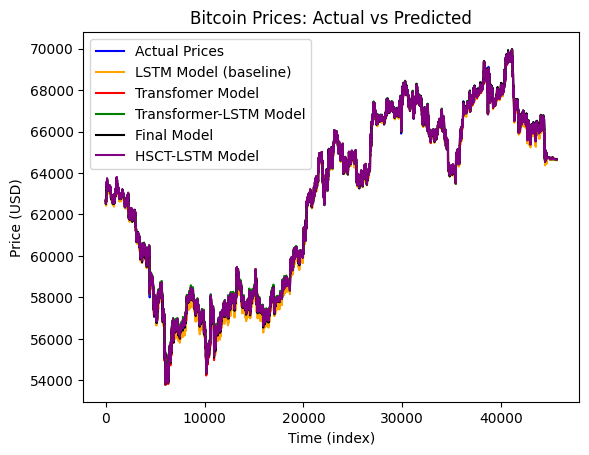

In [122]:
import numpy as np
import matplotlib.pyplot as plt
plt.plot(actuals, label='Actual Prices', color='blue')
# Plot predicted prices
plt.plot(baseline_pred, label='LSTM Model (baseline)', color='orange')
plt.plot(transformer_pred, label='Transfomer Model', color='red')
plt.plot(transformer_lstm_pred, label='Transformer-LSTM Model', color='green')
plt.plot(final_model_pred, label='Final Model', color='black')
plt.plot(HSCT_LSTM_pred, label='HSCT-LSTM Model', color='purple')
# Add title and labels to the graph
plt.title('Bitcoin Prices: Actual vs Predicted')
plt.xlabel('Time (index)')
plt.ylabel('Price (USD)')
# Add legend to differentiate between actual and predicted prices
plt.legend()
# Show the plot
plt.show()

# we did zoom in to show the differences

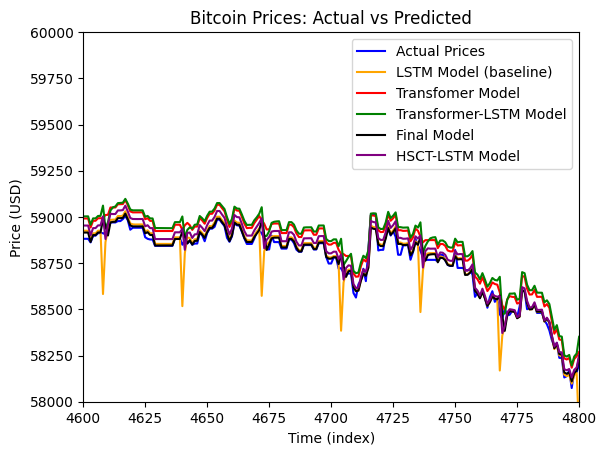

In [123]:
import numpy as np
import matplotlib.pyplot as plt
plt.plot(actuals, label='Actual Prices', color='blue')
# Plot predicted prices
plt.plot(baseline_pred, label='LSTM Model (baseline)', color='orange')
plt.plot(transformer_pred, label='Transfomer Model', color='red')
plt.plot(transformer_lstm_pred, label='Transformer-LSTM Model', color='green')
plt.plot(final_model_pred, label='Final Model', color='black')
plt.plot(HSCT_LSTM_pred, label='HSCT-LSTM Model', color='purple')
# Add title and labels to the graph
plt.title('Bitcoin Prices: Actual vs Predicted')
plt.xlabel('Time (index)')
plt.ylabel('Price (USD)')
plt.xlim([4600, 4800])  # Adjust these values to your preferred zoom range on the x-axis
plt.ylim([58000, 60000])
# Add legend to differentiate between actual and predicted prices
plt.legend()
# Show the plot
plt.show()